### Work left to do

##### 1(Abdul). Create a script that queries the Google Books API for each book in the books_data.csv dataset and retrieves the pageCount and averageRating fields from the response and adds them as columns to the enhanced_books_data.csv

##### Expected columns: book_title, page_count, average_rating 

##### 2(Joseph). Sentiment analysis of the review/text to produce a column with either a positive(1) or negative(1) sentiment; said column can be used as a feature in a ML model

##### 3. Four models have been built

###### 1. Linear regression - Joseph draft 
###### 2. K-nearest neighbors - Joseph draft 
###### 3. _ model - Brian 
###### 4. _ model - Griffin 

##### 4(everyone). Analysis and Evaluation of model performance/model comparison

##### 5(everyone). Lessons learned/things we would do differently/things we would do if we had more time 

# Everyone should be working in a single notebook. 

# Data pre-processing/filtering/cleaning

In [ ]:
pip install textblob

In [95]:
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from textblob import TextBlob

books_refined_file_path = './data/refined/filtered_books.csv'
book_ratings_file_path = './data/refined/filtered_book_ratings.csv'

In [24]:
books = pd.read_csv(books_refined_file_path, usecols=["title","ratings_count", "published_date"])

books['published_date'] = books['published_date'].astype(int)
books = books[books["ratings_count"] >= 20]

,title,published_date,ratings_count
22,The Rabbi's Cat,2005,25.0
62,The Castle in the Attic,2012,21.0
82,Dumb witness,2018,21.0
85,Jean Paul Sartres No Exit and the Flies,1976,22.0
115,The Gods of Mars,2020,26.0


In [25]:
book_ratings = pd.read_csv(book_ratings_file_path, usecols=["user_id", "title", "price", "rating", "review_text", "review_summary"])

In [26]:
book_ratings_sum = book_ratings.groupby('title')['rating'].sum()
book_ratings_sum = book_ratings_sum.to_frame('book_ratings_sum')

In [27]:
book_ratings_count = book_ratings.groupby('title')['rating'].size()
book_ratings_count = book_ratings_count.to_frame('book_ratings_count')

In [28]:
merged_book_attributes = books.merge(book_ratings, on='title', how='inner')\
                              .drop_duplicates(subset=['title', 'user_id'], keep=False)

merged_book_attributes = merged_book_attributes.merge(book_ratings_sum, on='title', how='left')
merged_book_attributes = merged_book_attributes.merge(book_ratings_count, on='title', how='left')

merged_book_attributes["books_average_rating"] = (merged_book_attributes['book_ratings_sum'] - merged_book_attributes['rating']) / (merged_book_attributes['book_ratings_count'] - 1)
merged_book_attributes['books_average_rating'] = merged_book_attributes['books_average_rating'].fillna(book_ratings['rating'].mean())
                                
merged_book_attributes = merged_book_attributes[['price', 'review_summary', 'review_text', 'books_average_rating', 'rating']]

merged_book_attributes['full_review_sentiment_score'] = merged_book_attributes['review_text'].apply(lambda review: TextBlob(review).sentiment.polarity)
merged_book_attributes['review_summary_sentiment_score'] = merged_book_attributes['review_summary'].apply(lambda review_summary: TextBlob(review_summary).sentiment.polarity)

merged_book_attributes.drop('review_summary', axis=1, inplace=True)
merged_book_attributes.drop('review_text', axis=1, inplace=True)

columns = ['price', 'full_review_sentiment_score', 'review_summary_sentiment_score', 'books_average_rating', 'rating']
merged_book_attributes = merged_book_attributes.reindex(columns=columns)

merged_book_attributes.head()

,price,full_review_sentiment_score,review_summary_sentiment_score,books_average_rating,rating
0,16.93,0.130353,0.50,4.435897,4.0
1,16.93,0.186603,0.65,4.410256,5.0
2,16.93,0.169697,0.80,4.410256,5.0
3,16.93,0.173779,0.60,4.410256,5.0
4,16.93,0.126473,0.00,4.410256,5.0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(merged_book_attributes[['price', 'full_review_sentiment_score', 'review_summary_sentiment_score', 'books_average_rating']], merged_book_attributes[['rating']], test_size=0.2, random_state=42)

# Linear regression

In [141]:
lnr_regressor = LinearRegression()

In [142]:
lnr_regressor.fit(X_train, y_train)

LinearRegression()

In [143]:
ratings_y_pred = lnr_regressor.predict(X_test)

In [144]:
print(f"Coefficients: {lnr_regressor.coef_}")
print(f"r2 score on test data: {r2_score(y_test, ratings_y_pred)}")

Coefficients: [[-3.66826587e-05  1.52742697e+00  6.91405568e-01  6.91406782e-01]]
r2 score on test data: 0.24668842303510563


# K-nearest neighbors 

In [135]:
knn_regressor = KNeighborsRegressor()
param_grid = {'n_neighbors': range(1, 17), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best r2 score:", grid_search.best_score_)

Best parameters: {'n_neighbors': 16, 'weights': 'distance'}
Best r2 score: 0.3355709779470947


In [136]:
best_params = grid_search.best_params_
knn_regressor = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

In [138]:
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=16, weights='distance')

In [139]:
print(f"r2 score on test data: {knn_regressor.score(X_test, y_test)}")

r2 score on test data: 0.3661865999841206


In [ ]:
print(f"r2 score on test data: {rf_regressor.score(X_test, y_test)}")

In [60]:
knn_models = []
for k in range(1, 17):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_models.append(knn_regressor)

In [61]:
mse_values = []
for index, knn_regressor in enumerate(knn_models):
    knn_regressor.fit(X_train, y_train)
    y_pred = knn_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

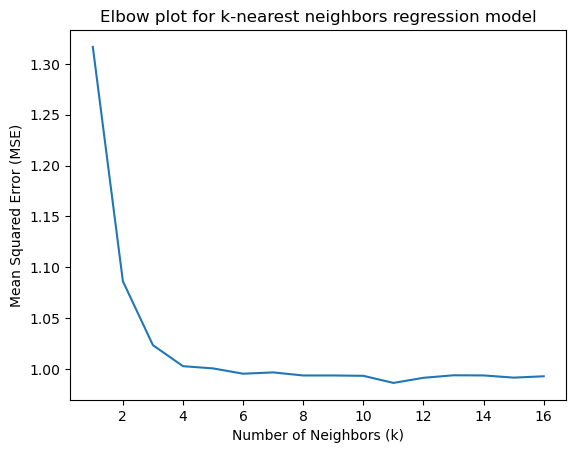

In [62]:
plt.plot([i for i in range(1, len(knn_models) + 1)], mse_values)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Elbow plot for k-nearest neighbors regression model')
plt.show()

# Random Forests

In [119]:
param_grid = {
    "n_estimators": [x for x in range(200, 2001, 200)],
    "max_features": ["log2", "sqrt"],
    "max_depth": [x for x in range(10, 110, 10)],
    "min_samples_split": [2, 4, 8],
    "bootstrap": [True, False]
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, n_jobs=-1, cv=5, scoring='r2')

random_search.fit(X_train, y_train.values.ravel())

print("Best parameters:", random_search.best_params_)
print("Best r2 score:", random_search.best_score_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Best r2 score: 0.6195762727635872


In [132]:
best_params = random_search.best_params_
rf_regressor = RandomForestRegressor(n_estimators=best_params['n_estimators'], min_samples_split=best_params['min_samples_split'], max_features=best_params['max_features'], max_depth=best_params['max_depth'], bootstrap=best_params['bootstrap'])

In [133]:
rf_regressor.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='log2',
                      min_samples_split=4, n_estimators=1000)

In [ ]:
print(f"r2 score on test data: {rf_regressor.score(X_test, y_test)}")

# Neural Network

In [ ]:
from io import BytesIO

import boto3 as b3
import pandas as pds
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# Initial set-up: --------------------------------------------------------------------------------

# Grab s3
s3 = b3.client('s3')

# Bucket set-up
the_bucket = 'groupproject-balducci'
books_key = 'path/to/books_data.csv'
ratings_key = 'path/to/books_rating.csv'

# Fetch books data and store
books_data_object = s3.get_object(Bucket = the_bucket, Key = books_key)
books_data = pds.read_csv(BytesIO(books_data_object['Body'].read()))

# Fetch user ratings data and store
books_rating_object = s3.get_object(Bucket = the_bucket, Key = ratings_key)
books_rating = pds.read_csv(BytesIO(books_rating_object['Body'].read()))

# Merge data together (Merge with 'Title' as the key and only merge rows that occur in both files)
all_data = pds.merge(books_data, books_rating, on = 'Title', how = 'inner')

In [ ]:
# Data Preprocessing: ----------------------------------------------------------------------------

# Remove any rows with NaN values
all_data = all_data.dropna()

# Create a matrix of users (rows) to books (columns) based on user ratings
rating_matrix = all_data.pivot_table(index = 'User_id', columns = 'Title', values = 'review/score')

# If user hasn't rated a book add a zero
rating_matrix = rating_matrix.fillna(0)

In [ ]:
# Neural Network Model: --------------------------------------------------------------------------

# Grab counts:
user_count = len(rating_matrix.index)
item_count = len(rating_matrix.columns)

# Feature count per user (Smaller is less costly but less accurate)
embedding_size = 10

# Model start
model = Sequential()

# Using User_id as the input (1)
model.add(Input(shape = [1]))

# Convert each user to into a profile of embedding_size
model.add(Embedding(input_dim = user_count, output_dim = embedding_size, input_length = 1))

# Flatten profiles into single lines
model.add(Flatten())

# Create the hidden layer (64 neurons)
model.add(Dense(64, activation = 'relu'))

# Create the output layer (sigmoid for generating probability)
model.add(Dense(item_count, activation = 'sigmoid'))

# Compile time! (Using Regression)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])